In [1]:
import glob 

import numpy as np

import jax.numpy as jnp

# plotting imports
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from copy import copy
params = {
   'axes.labelsize': 10,
   'font.size': 10,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'axes.titlesize':10,
   'text.usetex': True,
   'font.family':'serif',
   'font.serif':'Computer Modern'
   }
matplotlib.rcParams.update(params)
matplotlib.rcParams["font.serif"] = "Computer Modern Roman"
matplotlib.rcParams["font.family"] = "Serif"
matplotlib.rcParams['text.latex.preamble'] = r'\renewcommand{\mathdefault}[1][]{}'

from matplotlib.markers import MarkerStyle
import matplotlib as mpl

In [2]:
print(len(glob.glob("results_250311/*.dat")))

data = np.array([np.genfromtxt(f) for f in glob.glob("results_250311/*.dat")])

3000


In [3]:
data_sorted = data[np.argsort(data[:,0])]

indexes = np.argwhere(np.diff(data_sorted[:,0]) > 0)
indexes = np.append(indexes, len(data_sorted)-1)
indexes = indexes.flatten()

snrs = data_sorted[:,0][indexes].flatten()

means = []
photon_prob = []

counter = 0
mean_i = jnp.zeros(3)
photon_counts = 0
for i in range(len(data_sorted)):
    if i in indexes and i != 0:
        means.append(mean_i/counter)
        photon_prob.append(photon_counts/counter)
        counter = 0
        photon_counts = 0
        mean_i = jnp.zeros(3)
    mean_i += data_sorted[i,1:4]
    counter += 1

    if data_sorted[i,1] < 1.5e3:
        photon_counts += 1

means = np.array(means)
photon_prob = np.array(photon_prob)

In [4]:
photon_prob

array([0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.  ,
       0.01, 0.01, 0.02, 0.01, 0.04, 0.08, 0.08, 0.16, 0.25, 0.34, 0.35,
       0.53, 0.63, 0.77, 0.88, 0.95, 0.97, 0.98, 1.  ])

In [5]:
snr_data = np.genfromtxt('../hierarchical_EOS/bns_pm_dataset_updated.dat')

In [6]:
from scipy.interpolate import interp1d
snr_array = np.logspace(-1,jnp.log10(6),100)

cdf_CE1 = interp1d(np.sort(snr_data[:,-3]), np.linspace(1,0,len(snr_data)), fill_value=(1,0), bounds_error=False)(snr_array)
cdf_CE2silica = interp1d(np.sort(snr_data[:,-2]), np.linspace(1,0,len(snr_data)), fill_value=(1,0), bounds_error=False)(snr_array)

In [7]:
from numpyro.distributions import Poisson

prob_photon = (1-np.exp(Poisson(snr_array**2/2).log_prob(0)))

/home/ethan.payne/.conda/envs/ve310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
prior_samples = np.random.uniform(1.5e3,4e3, (10000,2000))
min_prior = np.min(np.diff(np.percentile(prior_samples, [16,84], axis=1), axis=0))

print(min_prior)

1587.585029005995


In [20]:

from jax import random

samples = []

for i in range(10):
    samples_arr = Poisson(snr_array**2/2).sample(random.PRNGKey(np.random.randint(0,100000)), sample_shape=(100, 10000,))

    samples.append(samples_arr)

samples = jnp.concatenate(samples, axis=1)

/local/ethan.payne/ipykernel_1122914/1097688037.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['', r'$10^{-1}$', r'$1$'])


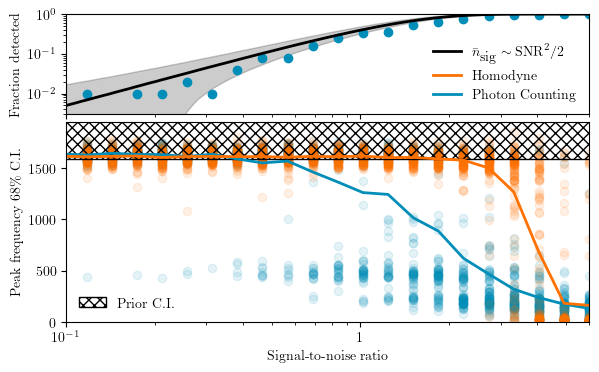

In [22]:
fig, ax = plt.subplots(2,1,figsize=(6.75,4), sharex=True, gridspec_kw={'height_ratios': [1, 2], 'hspace':0.05})

ax[1].scatter(data[:,0], data[:,1], color='#008eb8ff', alpha=0.1, edgecolor=None)
ax[1].scatter(data[:,0], data[:,3], color='#ff7100ff', alpha=0.1, edgecolor=None)

ax[1].set_xscale('log')
ax[1].set_xlim(1e-1,6)
ax[1].set_ylim(0,1.95e3)

ax[0].semilogy(snr_array, np.mean(np.mean(samples > 0, axis=0), axis=0), color='k', lw=2)
ax[0].fill_between(snr_array, np.mean(np.mean(samples > 0, axis=0), axis=0) - 1.645*np.std(np.mean(samples > 0, axis=0), axis=0), 
    np.mean(np.mean(samples > 0, axis=0), axis=0) + 1.645*np.std(np.mean(samples > 0, axis=0), axis=0), color='k', alpha=0.2)

ax[0].scatter(snrs, photon_prob, color='#008eb8ff')

legend_handles = [ 
    Line2D([0], [0], color='k', lw=2, label=r'$\bar{n}_\textrm{sig}\sim\textrm{SNR}^2/2$'),
    Line2D([0], [0], color='#ff7100ff', lw=2, label=r'Homodyne'),
    Line2D([0], [0], color='#008eb8ff', lw=2, label=r'Photon Counting')]

ax[0].set_ylim(3e-3,1)
ax[0].legend(handles=legend_handles, frameon=False, loc='lower right')
ax[0].set_ylabel(r'Fraction detected')
ax[1].set_xlabel(r'Signal-to-noise ratio')
ax[1].set_ylabel(r'Peak frequency 68\% C.I.')

ax[1].fill_between([0, 10], min_prior*jnp.ones(2), 2e3*jnp.ones(2), color="none",hatch="XXX",edgecolor="k", label='Prior C.I.')
ax[1].plot(snrs, means[:,0], color='#008eb8ff', lw=2)
ax[1].plot(snrs, means[:,2], color='#ff7100ff', lw=2)
ax[1].legend(frameon=False)

ax[1].set_xticklabels(['', r'$10^{-1}$', r'$1$'])
#ax[0].set_yticklabels(['', r'$10^{-2}$', r'$1$'])

fig.savefig('snr_summary.pdf', bbox_inches='tight')

In [11]:
snr_array

array([0.1       , 0.10422241, 0.10862311, 0.11320963, 0.11798981,
       0.12297182, 0.1281642 , 0.13357582, 0.13921595, 0.14509422,
       0.1512207 , 0.15760586, 0.16426063, 0.17119639, 0.17842501,
       0.18595885, 0.1938108 , 0.20199429, 0.21052333, 0.21941249,
       0.22867699, 0.23833268, 0.24839607, 0.25888437, 0.26981554,
       0.28120827, 0.29308204, 0.30545718, 0.31835484, 0.33179709,
       0.34580694, 0.36040833, 0.37562626, 0.39148675, 0.40801694,
       0.4252451 , 0.4432007 , 0.46191447, 0.4814184 , 0.50174588,
       0.52293166, 0.54501199, 0.56802465, 0.59200899, 0.61700606,
       0.6430586 , 0.67021119, 0.69851027, 0.72800426, 0.75874361,
       0.7907809 , 0.82417093, 0.85897083, 0.89524012, 0.93304086,
       0.9724377 , 1.01349803, 1.0562921 , 1.10089312, 1.14737737,
       1.19582438, 1.24631702, 1.29894167, 1.35378835, 1.41095088,
       1.47052706, 1.53261878, 1.59733227, 1.66477824, 1.73507205,
       1.80833395, 1.88468928, 1.96426864, 2.04720817, 2.13364